# Project Manager Assistant Agent

## Overview
This tutorial demonstrates how to create a an AI agent that assists in project management tasks including creating actionable tasks from a given project description, identify the dependency within the tasks, create a task execution schedule for the project, and assign the individual tasks to project members based on their expertise and experience. This application uses a combination of custom functions, structured output, and an agent that can streamline the project management, in particular during the project initation / setup process. 


## Motivation
Effective management is key to project success. It already starts, with the setup of the project, definition of tasks, scheduling and allocation of team members. However, with increasing complexity of the project, this task becomes more and more challenging and time consuming frequently requiring days of planning involving several members of the organization.

The ```Project Manager Assistant Agent``` was created to transfrom how projects are initiated by introducing automation, intelligence, and precision into the process. It enables project managers to seamless translate project description into structure, actionable plans, mapping dependencies for better workflow alignment and assign tasks based on team members' expertise and experience. In addition, it creates risks scores for the individual tasks allowing overall project risk assessment. This overall project risk score is used as part of a self-reflection to further improve the schedule and task assignment to reduce the project risks. (see details on the implementation)


### Benefits
This AI-driven approach reduces the burden of manual planning and eliminates redundancies, allowing project managers to shift their focus to higher-level strategy and decision. making. 

### Key Components
<ol>
    <li>
        <b>LangGraph</b>: Organize the overall workflow of the agent, managing the flow of infromation between different nodes and stages of the agent
    </li>
    <li>
        <b>GPT-4o</b>: Extracts actionable items from the project description, map dependencies, schedules tasks, allocate tasks to team, and assess the risks
    </li>

</ol>

### Key Classes
<b>State Management</b>
<br/>
<ol>
    <li>
        <b>AgentState</b>
        <ul>
            <li><b>project_description</b>: Description of the project</li>
            <li><b>team</b>: The team available</li>
            <li><b>tasks</b>: List of tasks</li>
            <li><b>dependencies</b>: List of dependencies of tasks</li>
            <li><b>schedule</b>: Project schedule created by the agent</li>
            <li><b>task_allocations</b>: List of team member and task allocated to them</li>
            <li><b>risks</b>: Risks associated with the tasks</li>
            <li><b>iteration_number</b>: Number of times the agent will go into self-reflection</li>
            <li><b>max_iteration</b>: The maximum number of time it can go into feedback loop to improve itself</li>
            <li><b>insights</b>: Insights generated to improve the response</li>
            <li><b>schedule_iteration</b>: Schedule per iteration </li>
            <li><b>task_allocations_iteration</b>: Task allocation per iteration</li>
            <li><b>risks_iteration</b>: Risks per task per iteration</li>
            <li><b>project_risk_score_iterations</b>: Projecr risk score per iteration</li>
        </ul>
    </li>
    <li>
        <b>Task</b>
        <ul>
            <li><b>id</b>: Id for the task</li>
            <li><b>task_name</b>: Name of the task</li>
            <li><b>task_description</b>: Description of task</li>
            <li><b>estimated_day</b>: Estimated time the task will take to complete</li>
        </ul>
    </li>
    <li>
        <b>TaskDependency</b>
        <ul>
            <li><b>task</b>: Name of the task</li>
            <li><b>dependent_task</b>: Name of the dependent task</li>
        </ul>
    </li>
    <li>
        <b>Team Member</b>
        <ul>
            <li><b>name</b>: Name of the team member</li>
            <li><b>profile</b>: Profile of the member</li>
        </ul>
    </li>
    <li>
        <b>Team</b>
        <ul>
            <li><b>team_member</b>: Members in the team</li>
        </ul>
    </li>
    <li>
        <b>TaskAllocation</b>
        <ul>
            <li><b>task</b>: Name of the task allocated</li>
            <li><b>team_member</b>: To whom the task is allocated</li> 
        </ul>
    </li>
    <li>
        <b>TaskSchedule</b>
        <ul>
            <li><b>task</b>: Task name</li>
            <li><b>start_day</b>: When the task should start</li>
            <li><b>end_day</b>: When the task will end</li>
        </ul>
    </li>
    <li>
        <b>TaskList</b>
        <ul>
            <li><b>tasks</b>: List of tasks name</li>
        </ul>
    </li>
    <li>
        <b>DependencyList</b>
        <ul>
            <li><b>dependencies</b>: List of dependent tasks</li>
        </ul>
    </li>
    <li>
        <b>Schedule</b>
        <ul>
            <li><b>schedule</b>: List of task schedule</li>
        </ul>
    </li>
    <li>
        <b>TaskAllocationList</b>
        <ul>
            <li><b>task_allocations</b>: List of allocated tasks</li>
        </ul>
    </li>
    <li>
        <b>Risk</b>
        <ul>
            <li><b>task</b>: Task name</li>
            <li><b>score</b>: Risk score for that task</li>
        </ul>
    </li>
    <li>
        <b>RiskList</b>
        <ul>
            <li><b>risks</b>: List of risks</li>
        </ul>
    </li>
</ol>


### Key Nodes and Functions
<ol>
    <li>
        <b>task_generation</b>: Node that will extract tasks from given project description
    </li>
    <li>
        <b>task_dependencies</b>: Node that will evaluate the dependencies between the tasks
    </li>
    <li>
        <b>task_scheduler</b>: Node that will schedule tasks based on dependencies and team availability
    </li>
    <li>
        <b>task_allocator</b>: Node that will allocate tasks to team members
    </li>
    <li>
        <b>risk_assessor</b>: Node that analyze risk associated with schedule and allocation of task
    </li>
    <li>
        <b>insight_generator</b>: Node that generate insights from the schedule, task allocation and risk associated
    </li>
    <li>
        <b>router</b>: A helper function that will route the agent to the appropriate node based on the project description
    </li>
</ol>

## Visual Representation of the Agent

![Project Manager Assistant](../images/project_manager_agent.png)

## Implementation
In the following section, we provide a detailed overview how to implement the Project Manager Assistant Agent.

### Install and import tutorial specific libraries

In [1]:
!pip install langchain langchain-openai pandas plotly networkx pyvis openai -q

In [2]:
import os
import uuid
import pandas as pd
import plotly.express as px
import networkx as nx
from pyvis.network import Network
from datetime import datetime, timedelta
from typing import List, TypedDict
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI, ChatOpenAI
from langgraph.graph import StateGraph, START,END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display, Markdown, HTML
from dotenv import load_dotenv

# Load environment variables
load_dotenv(override=True)

True

In [3]:
# Define your model provider
model_provider = 'Azure' # 'Azure' or 'OpenAI' or 'Gemini'ArithmeticError

### Instantiate LLM model

In [4]:
# Based on model_provider load the language model
if model_provider == 'Azure':
    """
    Define your environmental variables under .venv:
        - AZURE_OPENAI_API_KEY    
        - OPENAI_API_VERSION
        - AZURE_OPENAI_ENDPOINT
    """
    llm = AzureChatOpenAI(
        deployment_name='gpt-4o-mini',  # Your actual deployment name
    )
elif model_provider == 'OpenAI':
    """
    Define your environmental variables under .venv:
        - OPENAI_API_KEY
        - OPENAI_API_BASE
    """
    llm = ChatOpenAI(model="gpt-4o-mini")
else:
    print('Implement your own llm loader')

## Implementation

In the following section, we will step-by-step implement:
- The data classes,
- Agent state,
- Nodes and function (used as a router),
- and the workflow of the agent.

So let's create all required data classes first:

In [5]:
# Data Models
class Task(BaseModel):
    id: uuid.UUID = Field(default_factory=uuid.uuid4, description="Unique identifier for the task")
    task_name: str = Field(description="Name of the task")
    task_description: str = Field(description="Description of the task")
    estimated_day: int = Field(description="Estimated number of days to complete the task")

class TaskList(BaseModel):
    tasks: List[Task] = Field(description="List of tasks")

class TaskDependency(BaseModel):
    """Task dependency model"""
    task: Task = Field(description="Task")
    dependent_tasks: List[Task] = Field(description="List of dependent tasks")

class TeamMember(BaseModel):
    name: str = Field(description="Name of the team member")
    profile: str = Field(description="Profile of the team member")

class Team(BaseModel):
    team_members: List[TeamMember] = Field(description="List of team members")

# Iterative assessment
class TaskAllocation(BaseModel):
    """Task allocation class"""
    task: Task = Field(description="Task")
    team_member: TeamMember = Field(description="Team members assigned to the task")

class TaskSchedule(BaseModel):
    """Schedule schedule class"""
    task: Task = Field(description="Task")
    start_day: int = Field(description="Start day of the task")
    end_day: int = Field(description="End day of the task")

# Lists
class DependencyList(BaseModel):
    """List of task dependencies"""
    dependencies: List[TaskDependency] = Field(description="List of task dependencies")

class Schedule(BaseModel):
    """List of task schedules"""
    schedule: List[TaskSchedule] = Field(description="List of task schedules")

class TaskAllocationList(BaseModel):
    """List of task allocations"""
    task_allocations: List[TaskAllocation] = Field(description="List of task allocations")

# Iteration
class TaskAllocationListIteration(BaseModel):
    """List of task allocations for each iteration"""
    task_allocations_iteration: List[TaskAllocationList] = Field(description="List of task allocations for each iteration")

class ScheduleIteration(BaseModel):
    """List of task schedules for each iteration"""
    schedule: List[Schedule] = Field(description="List of task schedules for each iteration")

class Risk(BaseModel):
    """Risk of a task"""
    task: Task = Field(description="Task")
    score: str = Field(description="Risk associated with the task")

class RiskList(BaseModel):
    """List of risks for each iteration"""
    risks: List[Risk] = Field(description="List of risks")

class RiskListIteration(BaseModel):
    """List of risks for each iteration"""
    risks_iteration: List[RiskList] = Field(description="List of risks for each iteration")

In the next step, let's create the AgentState. The `schedule_iteration`, `task_allocations_iteration`, `risks_iteration` are introduced to generate structured 'memory' for the self-reflection cycles.

In [6]:
class AgentState(TypedDict):
    """The project manager agent state."""
    project_description: str
    team: Team
    tasks: TaskList
    dependencies: DependencyList
    schedule: Schedule
    task_allocations: TaskAllocationList
    risks: RiskList
    iteration_number: int
    max_iteration: int
    insights: List[str]
    schedule_iteration: List[Schedule]
    task_allocations_iteration: List[TaskAllocationList]
    risks_iteration: List[RiskListIteration]
    project_risk_score_iterations: List[int]

Well done, let's create the required nodes. As a quick recap:

 In LangGraph a node is defined as a function which has an argument the `AgentState`. Within the node certain attributes of the field state is updated which at the end of the node is returned to the workflow manager and passed to the next node. Inside the nodes, LLM's are used to generate (non)-structured response.

In this tutorial we have implemented the nodes based on th following pattern:

```
def task_generation_node(state: AgentState):
 """LangGraph node that will extract tasks from given project description"""
    description = state["project_description"]
    prompt = f"""You are an experienced project description analyzer. Analyze the 
    project description '{description}' and create a list of actionable and
    realistic tasks with estimated time (in days) to complete each task.
    If the task takes longer than 5 days, break it down into independent smaller tasks.
    """
    structure_llm = llm.with_structured_output(TaskList)
    tasks: TaskList = structure_llm.invoke(prompt)
    state['tasks'] = tasks
    return state
```
In almost all nodes, we used:
- `llm.with_structured_output(<structure>)` - generating structured output. 

The .with_structured_output() method enables models with native APIs for structured outputs, such as function calling or JSON mode, to reliably produce outputs as objects based on a defined schema. The schema can be specified using a TypedDict, JSON Schema, or a Pydantic class, determining whether the output is a dictionary or a Pydantic object.

The only exception is the insight_generation_node where only `str` as requested from the llm and the required interface only `llm.invoke(prompt)`

In [7]:
# Workflow Nodes
def task_generation_node(state: AgentState):
    """LangGraph node that will extract tasks from given project description"""
    description = state["project_description"]
    prompt = f"""You are an experienced project description analyzer. Analyze the 
        project description '{description}' and create a list of actionable and
        realistic tasks with estimated time (in days) to complete each task.
        If the task takes longer than 5 days, break it down into independent smaller tasks.
        """
    structure_llm = llm.with_structured_output(TaskList)
    tasks: TaskList = structure_llm.invoke(prompt)
    return {"tasks": tasks}

def task_dependency_node(state: AgentState):
    """Evaluate the dependencies between the tasks"""
    tasks = state["tasks"]
    prompt = f"""
        Assess dependency between tasks {tasks}. For each task, identify the blocking tasks.
        Provide for each task the list of dependent tasks.
        """
    structure_llm = llm.with_structured_output(DependencyList)
    dependencies: DependencyList = structure_llm.invoke(prompt)
    return {"dependencies": dependencies}

def task_scheduler_node(state: AgentState):
    """LangGraph node that will schedule tasks based on dependencies and team availability"""
    dependencies = state["dependencies"]
    tasks = state["tasks"]
    insights = state["insights"] #"" if state["insights"] is None else state["insights"].insights[-1]
    prompt = f"""You are a project scheduler. You have the following {tasks}.
        Schedule tasks based on the dependencies {dependencies},
        Take into account the insights {insights}.
        Take into previous schedule iteration if any {state["schedule_iteration"]}.
        """
    schedule_llm = llm.with_structured_output(Schedule)
    schedule: Schedule = schedule_llm.invoke(prompt)
    state["schedule"] = schedule
    state["schedule_iteration"].append(schedule)
    return state

def task_allocation_node(state: AgentState):
    """LangGraph node that will allocate tasks to team members"""
    tasks = state["tasks"]
    schedule = state["schedule"]
    team = state["team"]
    insights = state["insights"] #"" if state["insights"] is None else state["insights"].insights[-1]
    prompt = f"""You are a project manager. You have tasks {tasks} and schedule {schedule}.
        Allocate tasks to team members {team} based on their skills and availability,
        such that there is no overlapping task assigned for a team member.
        Take into account any available insights {insights}
        Take into account any previous task allocation {state["task_allocations_iteration"]}.
        Ensure that no team member has 2 tasks assigned for the same time period. 
        """
    structure_llm = llm.with_structured_output(TaskAllocationList)
    task_allocations: TaskAllocationList = structure_llm.invoke(prompt)
    state["task_allocations"] = task_allocations
    state["task_allocations_iteration"].append(task_allocations)
    return state

def risk_assessment_node(state: AgentState):
    """LangGraph node that analyse risk associated with schedule and allocation of task"""
    schedule = state["schedule"]
    task_allocations=state["task_allocations"]
    prompt = f"""You are an experienced project risk analyzer. You have to analyze the risk 
        task allocated {task_allocations} and the schedule {schedule} suggested for the task. Return
        a risk score for each assigned task. Risk score should be an integer between 0 and 10.
        If there is previous iteration available {state['risks_iteration']},
        and there is no change in task assignment (same team member, same task) assign the same risk score.
        """
    structure_llm = llm.with_structured_output(RiskList)
    risks: RiskList = structure_llm.invoke(prompt)
    project_task_risk_scores = [int(risk.score) for risk in risks.risks]
    project_risk_score = sum(project_task_risk_scores)
    state["risks"] = risks
    state["project_risk_score"] = project_risk_score
    state["iteration_number"] += 1
    state["project_risk_score_iterations"].append(project_risk_score)
    state["risks_iteration"].append(risks)
    return state

def insight_generation_node(state: AgentState):
    """LangGraph node that generate insights from the schedule, task allocation, and risk associated"""
    schedule = state["schedule"]
    task_allocations=state["task_allocations"]
    risks = state["risks"]
    prompt = f"""You are an experienced project manager. You have to generate critical insights
        based on the task allocation {task_allocations}, the schedule {schedule} suggested for the task
        and a risk analysis report {risks}. Return a list of critical insights that.
        Recommend different task assignments or schedule changes if necessary.    
    """
    #structure_llm=llm.with_structured_output"insights"].append(structure_llm.invoke(prompt))
    insights = llm.invoke(prompt).content
    return {"insights": insights}

The proposed agentic workflow contains a conditional routing in which the logic was built around the overall risk score of the project plan. The task scheduling and task assignment is carried out at least twice in a 'self-reflection' in order to minimize the overall project risk assigned in each iteration as part of the `risk_assessment_node`. If the risk was reduced the agent finishes its task, otherwise tries to self-reflect using an `insight_generation_node` from which the insights fed back to the scheduler_node.

In [8]:
def router(state: AgentState):
    """LangGraph node that will route the agent to the appropriate node based on the project description"""
    max_iteration = state["max_iteration"]
    iteration_number = state["iteration_number"]

    if iteration_number < max_iteration:
        if len(state["project_risk_score_iterations"])>1:
            if state["project_risk_score_iterations"][-1] < state["project_risk_score_iterations"][0]:
                return END
            else:
                return "insight_generator"
        else:
            return "insight_generator"
    else:
        return END

As a last remainign step, let's create an agentic workflow using LangGraph.

In [9]:
# Instantiate the workflow    
workflow = StateGraph(AgentState)

# Add nodes to the workflow
workflow.add_node("task_generation", task_generation_node)
workflow.add_node("task_dependencies", task_dependency_node)
workflow.add_node("task_scheduler", task_scheduler_node)
workflow.add_node("task_allocator", task_allocation_node)
workflow.add_node("risk_assessor", risk_assessment_node)
workflow.add_node("insight_generator", insight_generation_node)

# Add edges to the workflow
workflow.set_entry_point("task_generation")
workflow.add_edge("task_generation", "task_dependencies")
workflow.add_edge("task_dependencies", "task_scheduler")
workflow.add_edge("task_scheduler", "task_allocator")
workflow.add_edge("task_allocator", "risk_assessor")
workflow.add_conditional_edges("risk_assessor", router, ["insight_generator", END])
workflow.add_edge("insight_generator", "task_scheduler")

# Set up memory
memory = MemorySaver()

# Compile the workflow
graph_plan = workflow.compile(checkpointer=memory)

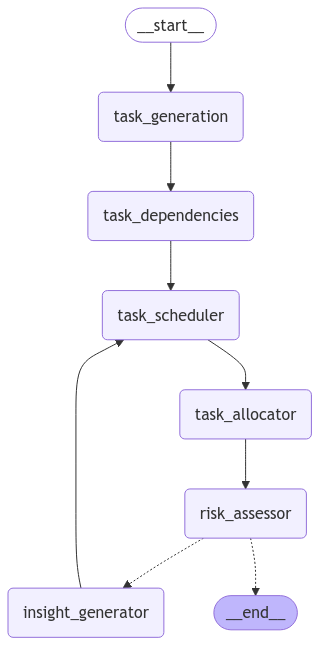

In [10]:
# To visualize the created workflow, we can use 
display(Image(graph_plan.get_graph(xray=1).draw_mermaid_png()))

## Usage Example

#### Initiate of the AgentState by defining an input
Our Project Manager Agent requires a project description (str) and a team (Team) input next to other initialization parameters.
In this tutorial we provide two dummy input under `data`. The team is defined as a csv file, composed of 2 colums: <i>Name</i>,<i>Profile Description</i>

In [11]:
def get_project_description(file_path:str):
    """Read the project description from the file"""
    with open(file_path, 'r') as file:
            content = file.read()

    return content

def get_team(file_path:str):
    """Read the team members from the CSV file"""
    team_df = pd.read_csv(file_path)
    team_members = [
            TeamMember(name=row['Name'], profile=row['Profile Description'])
            for _, row in team_df.iterrows()
        ]
    team = Team(team_members=team_members)

    return team

project_description = get_project_description("../data/project_manager_assistant/project_description.txt")
team = get_team("../data/project_manager_assistant/team.csv")

print(project_description)
print(team)

Our business aims to deliver a chatbot application for our customers to ensure 24/7 support and advice on product choices.
team_members=[TeamMember(name='Alice', profile=' Alice is a Frontend Developer skilled in HTML CSS JavaScript and React.'), TeamMember(name='Bob', profile=' Bob is a Backend Developer proficient in Python Django SQL and RESTful APIs.'), TeamMember(name='Charlie', profile=' Charlie is a Project Manager experienced in Agile methodologies team leadership project planning and risk management.'), TeamMember(name='David', profile=' David is a Full Stack Developer with expertise in both frontend (HTML CSS JavaScript) and backend (Node.js MongoDB) technologies.'), TeamMember(name='Eve', profile=' Eve is a DevOps Engineer skilled in CI/CD pipelines Docker Kubernetes and cloud services like AWS and Azure.'), TeamMember(name='Frank', profile=' Frank is a Junior Frontend Developer with knowledge in HTML CSS JavaScript and basic React.'), TeamMember(name='Grace', profile=' Grac

In [12]:
# Definition of the AgentState 
state_input = {
    "project_description": project_description,
    "team": team,
    "insights": "",
    "iteration_number": 0,
    "max_iteration": 3,
    "schedule_iteration": [],
    "task_allocations_iteration": [],
    "risks_iteration": [],
    "project_risk_score_iterations": []
}

In [13]:
# Invoke the agent
config = {"configurable": {"thread_id": "1"}}
for event in graph_plan.stream(state_input, config, stream_mode=["updates"]):
    "Print the different nodes as the agent progresses"
    print(f"Current node: {next(iter(event[1]))}")


Current node: task_generation
Current node: task_dependencies
Current node: task_scheduler
Current node: task_allocator
Current node: risk_assessor
Current node: insight_generator
Current node: task_scheduler
Current node: task_allocator
Current node: risk_assessor
Current node: insight_generator
Current node: task_scheduler
Current node: task_allocator
Current node: risk_assessor


In [14]:
# Retrive the final state
final_state = graph_plan.get_state(config).values
final_state

{'project_description': 'Our business aims to deliver a chatbot application for our customers to ensure 24/7 support and advice on product choices.',
 'team': Team(team_members=[TeamMember(name='Alice', profile=' Alice is a Frontend Developer skilled in HTML CSS JavaScript and React.'), TeamMember(name='Bob', profile=' Bob is a Backend Developer proficient in Python Django SQL and RESTful APIs.'), TeamMember(name='Charlie', profile=' Charlie is a Project Manager experienced in Agile methodologies team leadership project planning and risk management.'), TeamMember(name='David', profile=' David is a Full Stack Developer with expertise in both frontend (HTML CSS JavaScript) and backend (Node.js MongoDB) technologies.'), TeamMember(name='Eve', profile=' Eve is a DevOps Engineer skilled in CI/CD pipelines Docker Kubernetes and cloud services like AWS and Azure.'), TeamMember(name='Frank', profile=' Frank is a Junior Frontend Developer with knowledge in HTML CSS JavaScript and basic React.')

As we can see from the final_state the agentic workflow ended up having at least 2 iterations, and under `project_risk_score_iterations` we see evolution of the project risk score.

#### Visualize the results
To better understand the output of the agentic workflow - here we provide some visualizations for:
- Task depencies
- Project plan - Gantt-char for all created scenarios

In [15]:
# Visualize the dependencies
import networkx as nx
import matplotlib.pyplot as plt

# Create a NetworkX graph
G = nx.Graph()

for task in final_state['dependencies'].dependencies:
    G.add_node(task.task.task_name)
    for dependent_task in task.dependent_tasks:
        G.add_edge(task.task.task_name, dependent_task.task_name)

# Create a PyVis network
net = Network(notebook=True)

# Convert NetworkX graph to PyVis network
net.from_nx(G)

# Visualize the graph within the Jupyter Notebook
net.show("graph.html")

# Display the graph within the Jupyter Notebook
display(HTML("graph.html"))

graph.html


In [16]:
# Visalize Project timeline
number_of_iterations = final_state['iteration_number']

for i in range(number_of_iterations):
    ## Tasks schedule
    task_schedules = final_state['schedule_iteration'][i].schedule

    t = []
    # Iterate over the task_schedules and append each task's data to the DataFrame
    for task_schedule in task_schedules:
        t.append([
            task_schedule.task.task_name,
            task_schedule.start_day,
            task_schedule.end_day
        ])

    df_schedule = pd.DataFrame(t,columns=['task_name', 'start', 'end'])

    ## Tasks allocation
    task_allocations = final_state['task_allocations_iteration'][i].task_allocations

    t = []
    # Iterate over the task_schedules and append each task's data to the DataFrame
    for task_allocation in task_allocations:
        t.append([
            task_allocation.task.task_name,
            task_allocation.team_member.name
        ])

    df_allocation = pd.DataFrame(t,columns=['task_name', 'team_member'])

    df = df_allocation.merge(df_schedule, on='task_name')

    import plotly.express as px

    from datetime import datetime, timedelta
    # Get the current date
    current_date = datetime.today()

    # Convert start and end offsets to actual dates
    df['start'] = df['start'].apply(lambda x: current_date + timedelta(days=x))
    df['end'] = df['end'].apply(lambda x: current_date + timedelta(days=x))

    df.rename(columns={'team_member': 'Team Member'}, inplace=True)
    df.sort_values(by='Team Member', inplace=True)
    # Create a Gantt chart
    fig = px.timeline(df, x_start="start", x_end="end", y="task_name", color="Team Member", title=f"Gantt Chart - Iteration:{i+1} ")

    # Update layout for better visualization
    fig.update_layout(
        xaxis_title="Timeline",
        yaxis_title="Tasks",
        yaxis=dict(autorange="reversed"),  # Reverse the y-axis to have tasks in the vertical side
        title_x=0.5
    )

    # Show the plot
    fig.show()

## Comparison

As a comparison, we have implemented a simple agent composed of only 1 node aiming create a project plan as a 1-short.
The input remained the `project_description` and the `team`. The prompt became the combination of the each node - except the risk and insight generations.
The single node agent with the simplied stage could create a project plan - so qualitatively actually can solve the problem. However, a multi-agent solution allows for incorporation of self-reflection (in the future, human-in-the-loop), so iterative update to the plan can be made and additional information can be incorporated via user interactions.
In addition, the expected complex structured response may not always achieved by the LLM.




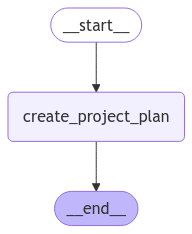

In [17]:
class ProjectPlan(BaseModel):
    tasks: TaskList
    dependencies: DependencyList
    schedule: Schedule
    task_allocations: TaskAllocationList

class SimpleAgentState(TypedDict):
    """The project manager agent state."""
    project_description: str
    team: Team
    tasks: TaskList
    dependencies: DependencyList
    schedule: Schedule
    task_allocations: TaskAllocationList

def project_plan_generation_node(state: SimpleAgentState):
    """LangGraph node that will extract tasks from given project description"""
    description = state["project_description"]
    team = state["team"]
    prompt = f"""You are an experienced project description analyzer, who needs to create a project plan.
        Create the project plan using the following steps:
        - Analyze the project description '{description}' and create a list of actionable and realistic tasks with estimated time (in days) to complete each task. If the task takes longer than 5 days, break it down into independent smaller tasks.
        - Assess dependency between tasks. For each task, identify the blocking tasks. Provide for each task the list of dependent tasks.
        - Schedule tasks based on the dependencies.
        - Allocate tasks to team members {team} based on their skills and availability, such that there is no overlapping task assigned for a team member. Ensure that no team member has 2 tasks assigned for the same time period.
    """
    structure_llm = llm.with_structured_output(ProjectPlan)
    project_plan: ProjectPlan = structure_llm.invoke(prompt)
    print(project_plan)
    return {"tasks": project_plan.tasks, "dependencies": project_plan.dependencies, "schedule": project_plan.schedule, "task_allocations": project_plan.task_allocations}


# Instantiate the workflow    
simple_workflow = StateGraph(SimpleAgentState)

# Add nodes to the workflow
simple_workflow.add_node("create_project_plan", project_plan_generation_node)

# Add edges to the workflow
simple_workflow.set_entry_point("create_project_plan")
simple_workflow.add_edge("create_project_plan", END)

# Set up memory
simple_memory = MemorySaver()

# Compile the workflow
simple_graph_plan = simple_workflow.compile(checkpointer=memory)

# To visualize the created workflow, we can use 
display(Image(simple_graph_plan.get_graph(xray=1).draw_mermaid_png()))



In [18]:
# Invoke the agent
config = {"configurable": {"thread_id": "2"}}
for event in simple_graph_plan.stream(state_input, config, stream_mode=["updates"]):
    "Print the different nodes as the agent progresses"
    print(f"Current node: {next(iter(event[1]))}")
    
simple_final_state = simple_graph_plan.get_state(config).values

tasks=TaskList(tasks=[Task(id=UUID('c8b1228b-013a-4ba8-b5a0-6e333f74fbaa'), task_name='Define project requirements', task_description='Gather and document the functional and non-functional requirements for the chatbot application.', estimated_day=3), Task(id=UUID('57b4fab7-8005-4e76-a9e4-3c1cc5429159'), task_name='Design chatbot architecture', task_description='Design the architecture for the chatbot, including the backend and frontend components.', estimated_day=5), Task(id=UUID('79ca2639-0749-4685-aa76-381173440836'), task_name='Develop chatbot backend', task_description='Implement the backend of the chatbot using Python and Django, including API development.', estimated_day=7), Task(id=UUID('9514210a-401d-4897-a435-0be1574626d5'), task_name='Set up database', task_description='Set up the database for storing user interactions and product information.', estimated_day=4), Task(id=UUID('073550a8-20eb-45ed-a354-6e295c166e53'), task_name='Integrate chatbot with database', task_descriptio

In [19]:
import pprint
pprint.pp(simple_final_state)

{'project_description': 'Our business aims to deliver a chatbot application '
                        'for our customers to ensure 24/7 support and advice '
                        'on product choices.',
 'team': Team(team_members=[TeamMember(name='Alice', profile=' Alice is a Frontend Developer skilled in HTML CSS JavaScript and React.'), TeamMember(name='Bob', profile=' Bob is a Backend Developer proficient in Python Django SQL and RESTful APIs.'), TeamMember(name='Charlie', profile=' Charlie is a Project Manager experienced in Agile methodologies team leadership project planning and risk management.'), TeamMember(name='David', profile=' David is a Full Stack Developer with expertise in both frontend (HTML CSS JavaScript) and backend (Node.js MongoDB) technologies.'), TeamMember(name='Eve', profile=' Eve is a DevOps Engineer skilled in CI/CD pipelines Docker Kubernetes and cloud services like AWS and Azure.'), TeamMember(name='Frank', profile=' Frank is a Junior Frontend Developer wi

In [20]:
## Tasks schedule
task_schedules = simple_final_state['schedule'].schedule

t = []
# Iterate over the task_schedules and append each task's data to the DataFrame
for task_schedule in task_schedules:
    t.append([
        task_schedule.task.task_name,
        task_schedule.start_day,
        task_schedule.end_day
    ])

df_schedule = pd.DataFrame(t,columns=['task_name', 'start', 'end'])

## Tasks allocation
task_allocations = simple_final_state['task_allocations'].task_allocations

t = []
# Iterate over the task_schedules and append each task's data to the DataFrame
for task_allocation in task_allocations:
    t.append([
        task_allocation.task.task_name,
        task_allocation.team_member.name
    ])

df_allocation = pd.DataFrame(t,columns=['task_name', 'team_member'])

df = df_allocation.merge(df_schedule, on='task_name')

import plotly.express as px

from datetime import datetime, timedelta
# Get the current date
current_date = datetime.today()

# Convert start and end offsets to actual dates
df['start'] = df['start'].apply(lambda x: current_date + timedelta(days=x))
df['end'] = df['end'].apply(lambda x: current_date + timedelta(days=x))

df.rename(columns={'team_member': 'Team Member'}, inplace=True)
df.sort_values(by='Team Member', inplace=True)
# Create a Gantt chart
fig = px.timeline(df, x_start="start", x_end="end", y="task_name", color="Team Member", title=f"Gantt Chart - Oneshot Project Plan")

# Update layout for better visualization
fig.update_layout(
    xaxis_title="Timeline",
    yaxis_title="Tasks",
    yaxis=dict(autorange="reversed"),  # Reverse the y-axis to have tasks in the vertical side
    title_x=0.5
)

# Show the plot
fig.show()

## Additional Considerations

Improvement Possibilities:
- Incorporating a 'human-in-the-loop' mechanism as part of the self-reflection process can significantly enhance the system's effectiveness. This approach allows for the introduction of additional, real-time information about the schedule and the availability or status of team members. For instance, if a team member is currently sick, the agent would typically still assign tasks to them due to a lack of awareness. By integrating human oversight, such critical updates can be communicated to the system, ensuring that tasks are reassigned appropriately and the workload is distributed more efficiently.
Limitations of the Approach:
- Incorporating an optimizer based on extracted features generated by the LLM can provide better and more reproducible scheduling and task allocation. So only leveraging the agent to produce structured content from the project description, task dependencies and team member profiles, then use the optimizer to create the project plan (task assignment). 

Limitations:
- The current approach relies on a Large Language Model (LLM) to assign risk scores to tasks. However, this method has inherent limitations. Even if the same person is assigned to the same task on the same schedule, the LLM may generate different risk scores each time. This inconsistency arises because the model's output can vary independently of the explicit details provided in the prompt. Consequently, this variability can lead to unpredictable risk assessments, potentially affecting the reliability and accuracy of task management.
- Although the prompts instructs to fullfill certain criteria, it is not always guaranteed, that it will achieve it. 

## References

Currently no references are added to the tutorial